# CNN - MNIST / Fashion MNIST / CIFAR10

### 0. 데이터셋 선택

In [1]:
datasets = ['mnist', 'fashion_mnist', 'cifar10']
dataset = datasets[2]
dataset

'cifar10'

### 1. 데이터셋 불러오기

In [2]:
from tensorflow.keras.datasets import mnist, fashion_mnist, cifar10

if dataset=='mnist':
    (train_images, train_labels), (test_images, test_labels) = mnist.load_data()
elif dataset=='fashion_mnist':
    (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
elif dataset=='cifar10':
    (train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [3]:
train_images.shape

(50000, 32, 32, 3)

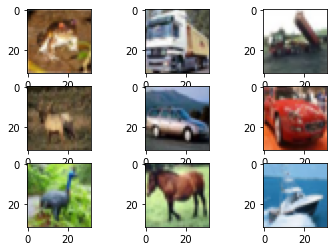

In [4]:
from matplotlib.pyplot import subplot, imshow, show

# Plot first nine images
for i in range(9):
    # define subplot
    subplot(330 + 1 + i)
    # plot raw pixel data
    imshow(train_images[i])

    # show the figure
show()

### 2. 파라메터 정의

In [5]:
IMG_ROWS = train_images.shape[1]
IMG_COLS = train_images.shape[2]

if (dataset=='mnist' or dataset=='fashion_mnist'):
    CHANNELS = 1
elif dataset=='cifar10':
    CHANNELS = train_images.shape[3]

NUM_CLASSES = 10
TEST_SIZE = 0.2
RANDOM_STATE = 42
BATCH_SIZE = 32

if dataset=='mnist':
    EPOCHS = 30
elif dataset=='fashion_mnist':
    EPOCHS = 100
elif dataset=='cifar10':
    EPOCHS = 500

### 3. 데이터 전처리

In [6]:
if (dataset=='mnist' or dataset=='fashion_mnist'):
    # mnist와 fashion_mnist는 채널 정보가 없어서 추가 해준다.
    train_images = train_images.reshape((60000, 28, 28, 1))
    test_images = test_images.reshape((10000, 28, 28, 1))

In [7]:
# 픽셀 값을 int(0~255) -> float32(0~1)
# 0~1 사이의 float32로 변경하면 min-max normalize 효과가 있음.
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

In [8]:
# 1은 그레이 채널 1개라는 의미
train_images.shape

(50000, 32, 32, 3)

In [9]:
from tensorflow.keras.utils import to_categorical

# one hot encoding  [5] -> [0,0,0,0,0,1,0,0,0,0]
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [10]:
# train데이터셋을 분리하여 Validate 데이터셋 생성
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [11]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((40000, 32, 32, 3), (40000, 10), (10000, 32, 32, 3), (10000, 10))

In [12]:
# ImageDataGenerator로 데이터 증대
from tensorflow.keras.preprocessing.image import ImageDataGenerator

if (dataset=='mnist' or dataset=='fashion_mnist'):
    train_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

elif dataset=='cifar10':
    train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False)

train_generator = train_datagen.flow(X_train, y_train, batch_size = BATCH_SIZE)

### 4. CNN 모델 생성

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout
from tensorflow.keras.layers import MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, Activation
from tensorflow.keras import regularizers, optimizers

def mnist_model():
    model = Sequential()

    # CNN : Feature Extractor + Classifier

    # 1. Feature Extractor
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal',
                     padding='same', input_shape=(IMG_ROWS, IMG_COLS, CHANNELS)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', 
                     padding='same'))
    model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal',
                     padding='same'))
    model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # 2. Classifier
    model.add(Flatten())
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    
    return model


def cifar10_model(lr = 0, dc = 0, dr = 0):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_uniform', 
                     kernel_regularizer=regularizers.l2(1e-4), padding='same', input_shape=(IMG_ROWS, IMG_COLS,CHANNELS)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_uniform', 
                     kernel_regularizer=regularizers.l2(1e-4), padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_uniform', 
                     kernel_regularizer=regularizers.l2(1e-4), padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_uniform', 
                     kernel_regularizer=regularizers.l2(1e-4), padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_uniform', 
                     kernel_regularizer=regularizers.l2(1e-4), padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_uniform', 
                     kernel_regularizer=regularizers.l2(1e-4), padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(256, activation='elu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(dr))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    # compile model
    opt = optimizers.Adam(learning_rate = lr, decay = dc)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model
    
    return model    

In [14]:
if (dataset=='mnist' or dataset=='fashion_mnist'):
    model = mnist_model()
elif dataset=='cifar10':
    model = cifar10_model(lr = 0.001, dc = 1e-5, dr = 0.5)
    
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        1

### 5. Compile

In [15]:
from tensorflow.keras.losses import categorical_crossentropy

model.compile(loss = categorical_crossentropy,
              optimizer="Adam",
              metrics=['accuracy'])

### 6. Call Back

In [16]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau, ModelCheckpoint

#'val_loss'가 줄지 않고 3 EPOCH동안 유지되면 학습율(learningRate를 20%로 줄인다.)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)

#'val_loss'가 3EPOCH동안 내려가지 않으면 학습을 중단한다.
es=EarlyStopping(monitor='val_loss', patience=20)

mc = ModelCheckpoint('cnn_best_model.h5', monitor='val_accuracy', mode='max', verbose = 1, save_best_only=True)

callback_list = [reduce_lr, es, mc]

In [17]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((40000, 32, 32, 3), (40000, 10), (10000, 32, 32, 3), (10000, 10))

In [18]:
#model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val),callbacks=[reduce_lr])
model.fit(train_generator, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val),callbacks=callback_list)

Epoch 1/500
1250/1250 [==============================] - 18s 11ms/step - loss: 1.8660 - accuracy: 0.3978 - val_loss: 1.4535 - val_accuracy: 0.5325

Epoch 00001: val_accuracy improved from -inf to 0.53250, saving model to cnn_best_model.h5
Epoch 2/500
1250/1250 [==============================] - 14s 11ms/step - loss: 1.3553 - accuracy: 0.5466 - val_loss: 1.2771 - val_accuracy: 0.5981

Epoch 00002: val_accuracy improved from 0.53250 to 0.59810, saving model to cnn_best_model.h5
Epoch 3/500
1250/1250 [==============================] - 14s 11ms/step - loss: 1.1871 - accuracy: 0.6200 - val_loss: 1.2461 - val_accuracy: 0.6195

Epoch 00003: val_accuracy improved from 0.59810 to 0.61950, saving model to cnn_best_model.h5
Epoch 4/500
1250/1250 [==============================] - 14s 11ms/step - loss: 1.0873 - accuracy: 0.6607 - val_loss: 0.9276 - val_accuracy: 0.7160

Epoch 00004: val_accuracy improved from 0.61950 to 0.71600, saving model to cnn_best_model.h5
Epoch 5/500
1250/1250 [============


Epoch 00037: val_accuracy improved from 0.86450 to 0.86740, saving model to cnn_best_model.h5
Epoch 38/500
1250/1250 [==============================] - 14s 11ms/step - loss: 0.5567 - accuracy: 0.8490 - val_loss: 0.5313 - val_accuracy: 0.8620

Epoch 00038: val_accuracy did not improve from 0.86740
Epoch 39/500
1250/1250 [==============================] - 14s 11ms/step - loss: 0.5522 - accuracy: 0.8495 - val_loss: 0.5108 - val_accuracy: 0.8678

Epoch 00039: val_accuracy improved from 0.86740 to 0.86780, saving model to cnn_best_model.h5
Epoch 40/500
1250/1250 [==============================] - 14s 11ms/step - loss: 0.5441 - accuracy: 0.8508 - val_loss: 0.5060 - val_accuracy: 0.8686

Epoch 00040: val_accuracy improved from 0.86780 to 0.86860, saving model to cnn_best_model.h5
Epoch 41/500
1250/1250 [==============================] - 14s 11ms/step - loss: 0.5468 - accuracy: 0.8503 - val_loss: 0.5002 - val_accuracy: 0.8704

Epoch 00041: val_accuracy improved from 0.86860 to 0.87040, saving

1250/1250 [==============================] - 14s 11ms/step - loss: 0.4745 - accuracy: 0.8700 - val_loss: 0.4664 - val_accuracy: 0.8762

Epoch 00076: val_accuracy did not improve from 0.88290
Epoch 77/500
1250/1250 [==============================] - 14s 11ms/step - loss: 0.4787 - accuracy: 0.8691 - val_loss: 0.4671 - val_accuracy: 0.8770

Epoch 00077: val_accuracy did not improve from 0.88290
Epoch 78/500
1250/1250 [==============================] - 14s 11ms/step - loss: 0.4761 - accuracy: 0.8688 - val_loss: 0.4477 - val_accuracy: 0.8816

Epoch 00078: val_accuracy did not improve from 0.88290
Epoch 79/500
1250/1250 [==============================] - 14s 11ms/step - loss: 0.4728 - accuracy: 0.8709 - val_loss: 0.4484 - val_accuracy: 0.8819

Epoch 00079: val_accuracy did not improve from 0.88290
Epoch 80/500
1250/1250 [==============================] - 14s 11ms/step - loss: 0.4711 - accuracy: 0.8696 - val_loss: 0.4557 - val_accuracy: 0.8789

Epoch 00080: val_accuracy did not improve from 0


Epoch 00115: val_accuracy did not improve from 0.88900
Epoch 116/500
1250/1250 [==============================] - 14s 11ms/step - loss: 0.4361 - accuracy: 0.8778 - val_loss: 0.4255 - val_accuracy: 0.8847

Epoch 00116: val_accuracy did not improve from 0.88900
Epoch 117/500
1250/1250 [==============================] - 14s 11ms/step - loss: 0.4323 - accuracy: 0.8806 - val_loss: 0.4321 - val_accuracy: 0.8851

Epoch 00117: val_accuracy did not improve from 0.88900
Epoch 118/500
1250/1250 [==============================] - 14s 11ms/step - loss: 0.4347 - accuracy: 0.8776 - val_loss: 0.4521 - val_accuracy: 0.8780

Epoch 00118: val_accuracy did not improve from 0.88900
Epoch 119/500
1250/1250 [==============================] - 14s 11ms/step - loss: 0.4329 - accuracy: 0.8806 - val_loss: 0.4394 - val_accuracy: 0.8817

Epoch 00119: val_accuracy did not improve from 0.88900
Epoch 120/500
1250/1250 [==============================] - 14s 11ms/step - loss: 0.4338 - accuracy: 0.8804 - val_loss: 0.434

1250/1250 [==============================] - 14s 11ms/step - loss: 0.4103 - accuracy: 0.8859 - val_loss: 0.4214 - val_accuracy: 0.8875

Epoch 00155: val_accuracy did not improve from 0.89260
Epoch 156/500
1250/1250 [==============================] - 14s 11ms/step - loss: 0.4095 - accuracy: 0.8848 - val_loss: 0.4276 - val_accuracy: 0.8870

Epoch 00156: val_accuracy did not improve from 0.89260
Epoch 157/500
1250/1250 [==============================] - 14s 11ms/step - loss: 0.4070 - accuracy: 0.8864 - val_loss: 0.4318 - val_accuracy: 0.8839

Epoch 00157: val_accuracy did not improve from 0.89260
Epoch 158/500
1250/1250 [==============================] - 14s 11ms/step - loss: 0.4048 - accuracy: 0.8881 - val_loss: 0.4121 - val_accuracy: 0.8915

Epoch 00158: val_accuracy did not improve from 0.89260
Epoch 159/500
1250/1250 [==============================] - 14s 11ms/step - loss: 0.4169 - accuracy: 0.8824 - val_loss: 0.4175 - val_accuracy: 0.8894

Epoch 00159: val_accuracy did not improve fr

KeyboardInterrupt: 

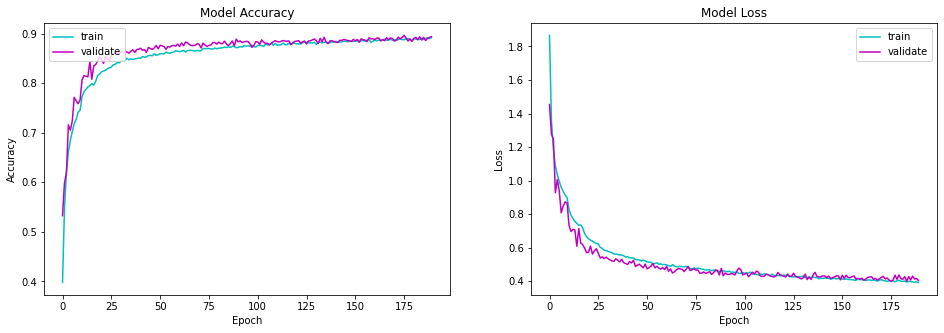

In [19]:
import matplotlib.pyplot as plt

def plot_model(history): 
    fig, axs = plt.subplots(1,2,figsize=(16,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy'], 'c') 
    axs[0].plot(history.history['val_accuracy'],'m') 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss'], 'c') 
    axs[1].plot(history.history['val_loss'], 'm') 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper right')
    plt.show()
    
plot_model(model.history)

테스트 데이터에서 모델을 평가해 보죠:

In [22]:
from tensorflow.keras.models import load_model

saved_model = load_model('cnn_best_model.h5')
test_loss, test_acc = saved_model.evaluate(test_images, test_labels)

313/313 [==============================] - 1s 3ms/step - loss: 0.4151 - accuracy: 0.8883


In [23]:
test_acc

0.8883000016212463

mnist : accuracy = 0.9945  
fashion_mnist : accuracy = 0.9440